In [136]:
#importing all necessary libraries
import os,sys,platform
import torch as torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
from scipy.io import arff
from copy import deepcopy as copy

#for decision tree
from sklearn import tree
from sklearn.preprocessing import LabelEncoder, TargetEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score as auc
from sklearn.metrics import confusion_matrix as cm
from sklearn.model_selection import train_test_split

from sklearn.metrics import ConfusionMatrixDisplay as showMatrix # for Classification

#To display images
from IPython.display import Image

In [137]:
#confirm and checking platform and sotware versions in software stack
print(f"Python Platform:{platform.platform()}")
print(f"Python {sys.version}")
print(f"Pandas Version: " , pd.__version__)
print(f"SkLearn Version: " , sk. __version__)

Python Platform:macOS-14.0-arm64-arm-64bit
Python 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:41:52) [Clang 15.0.7 ]
Pandas Version:  2.1.4
SkLearn Version:  1.3.0


In [138]:
#checking devices available,though I know this is unfortunately not usable here, I always include it in my code 
#So I can know what the run can "see"

available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
# print the names
for i in available_gpus:
    print(torch.cuda.get_device_properties(i).name)

# Prints 'Tesla V100-SXM2-16GB', for example
print(torch.version.cuda)
device = torch.device('cuda' if torch.cuda.is_available() or torch.backends.mps.is_available() else 'cpu')
print("Using device: ", device)

None
Using device:  cuda


In [149]:
#Acquire dataset
cancerdataraw = arff.loadarff('primary-tumor.arff')

#Import dataset into a panda dataframe
cancerdataraw = pd.DataFrame(cancerdataraw[0])

#View data values and information
cancerdataraw.info()
cancerdataraw.describe()
cancerdataraw.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              339 non-null    object
 1   sex              339 non-null    object
 2   histologic-type  339 non-null    object
 3   degree-of-diffe  339 non-null    object
 4   bone             339 non-null    object
 5   bone-marrow      339 non-null    object
 6   lung             339 non-null    object
 7   pleura           339 non-null    object
 8   peritoneum       339 non-null    object
 9   liver            339 non-null    object
 10  brain            339 non-null    object
 11  skin             339 non-null    object
 12  neck             339 non-null    object
 13  supraclavicular  339 non-null    object
 14  axillar          339 non-null    object
 15  mediastinum      339 non-null    object
 16  abdominal        339 non-null    object
 17  binaryClass      339 non-null    ob

age        sex histologic-type degree-of-diffe    bone bone-marrow  \
0   b'>=60'  b'female'            b'?'            b'?'   b'no'       b'no'   
1   b'>=60'    b'male'            b'?'       b'poorly'   b'no'       b'no'   
2  b'30-59'  b'female'        b'adeno'            b'?'   b'no'       b'no'   
3  b'30-59'  b'female'        b'adeno'            b'?'   b'no'       b'no'   
4  b'30-59'  b'female'        b'adeno'            b'?'   b'no'       b'no'   
5  b'30-59'    b'male'        b'adeno'            b'?'   b'no'       b'no'   
6  b'30-59'    b'male'        b'adeno'            b'?'  b'yes'       b'no'   
7  b'30-59'  b'female'        b'adeno'            b'?'  b'yes'       b'no'   
8  b'30-59'    b'male'        b'adeno'       b'fairly'   b'no'       b'no'   
9  b'30-59'  b'female'        b'adeno'         b'well'   b'no'       b'no'   

    lung  pleura peritoneum   liver   brain    skin    neck supraclavicular  \
0  b'no'   b'no'      b'no'  b'yes'   b'no'   b'no'   b'no'           b'no'   
1  b'no'   b'no'      b'no'  b'yes'   b'no'   b'no'   b'no'          b'yes'   
2  b'no'  b'yes'      b'no'   b'no'   b'no'  b'yes'   b'no'           b'no'   
3  b'no'   b'no'     b'yes'   b'no'   b'no'   b'no'   b'no'           b'no'   
4  b'no'  b'yes'     b'yes'   b'no'   b'no'   b'no'   b'no'           b'no'   
5  b'no'   b'no'      b'no'  b'yes'   b'no'   b'no'   b'no'           b'no'   
6  b'no'   b'no'      b'no'   b'no'   b'no'   b'no'   b'no'           b'no'   
7  b'no'   b'no'      b'no'   b'no'  b'yes'   b'no'   b'no'           b'no'   
8  b'no'   b'no'      b'no'   b'no'   b'no'   b'no'  b'yes'          b'yes'   
9  b'no'   b'no'     b'yes'  b'yes'   b'no'   b'no'   b'no'           b'no'   

  axillar mediastinum abdominal binaryClass  
0   b'no'       b'no'     b'no'        b'P'  
1   b'no'      b'yes'     b'no'        b'P'  
2  b'yes'       b'no'     b'no'        b'N'  
3   b'no'       b'no'     b'no'        b'N'  
4   b'no'       b'no'     b'no'        b'N'  
5   b'no'       b'no'     b'no'        b'N'  
6   b'no'       b'no'     b'no'        b'N'  
7   b'no'      b'yes'     b'no'        b'P'  
8   b'no'       b'no'     b'no'        b'N'  
9   b'no'       b'no'     b'no'        b'N'

Since the cancerdata is imported from a .arff file, it contains b' characters before every feature.  To correct this we should decode the strings in utf-8.  The output/label data is listed in pandas as an object despite being titled "binaryClass".  Ideally, preprocessing work would clean the data by filling in the missing data with values that didn't affect the overall model while also standardizing the data for better readability by anyone who would like to interpret the data and remove any noise caused by additional characters or improperly categorizing data types that could influence the model training.     

In [140]:
#Get rid of 'b' characters
d2l1 = cancerdataraw.select_dtypes([object])
d2l2 = d2l1.stack().str.decode('utf-8').unstack()
cancerdataraw = d2l2

display(cancerdataraw)

age     sex histologic-type degree-of-diffe bone bone-marrow lung  \
0     >=60  female               ?               ?   no          no   no   
1     >=60    male               ?          poorly   no          no   no   
2    30-59  female           adeno               ?   no          no   no   
3    30-59  female           adeno               ?   no          no   no   
4    30-59  female           adeno               ?   no          no   no   
..     ...     ...             ...             ...  ...         ...  ...   
334  30-59  female           adeno            well   no          no   no   
335  30-59    male      epidermoid          poorly  yes          no   no   
336  30-59  female           adeno            well   no          no   no   
337  30-59  female           adeno               ?  yes          no  yes   
338  30-59  female           adeno            well   no          no   no   

    pleura peritoneum liver brain skin neck supraclavicular axillar  \
0       no         no   yes    no   no   no              no      no   
1       no         no   yes    no   no   no             yes      no   
2      yes         no    no    no  yes   no              no     yes   
3       no        yes    no    no   no   no              no      no   
4      yes        yes    no    no   no   no              no      no   
..     ...        ...   ...   ...  ...  ...             ...     ...   
334     no        yes    no    no   no   no              no      no   
335     no         no    no    no  yes   no              no     yes   
336    yes        yes    no    no   no   no              no      no   
337    yes        yes   yes   yes   no   no              no      no   
338    yes        yes    no    no   no   no              no      no   

    mediastinum abdominal binaryClass  
0            no        no           P  
1           yes        no           P  
2            no        no           N  
3            no        no           N  
4            no        no           N  
..          ...       ...         ...  
334          no        no           N  
335          no        no           P  
336          no        no           N  
337          no       yes           N  
338          no        no           N  

[339 rows x 18 columns]

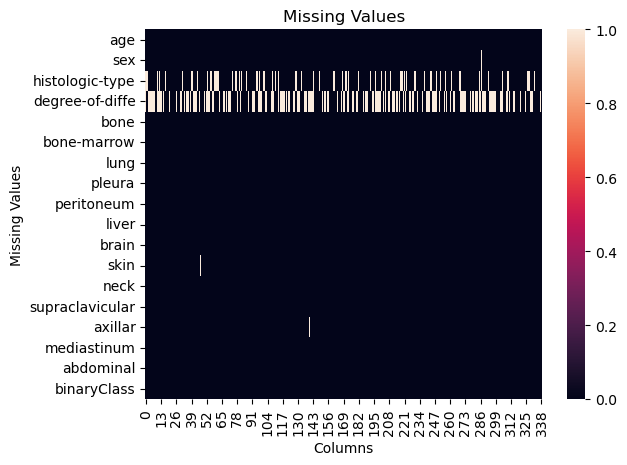

In [141]:
#Perform our own Data Visualization - Plot a missing data heatmap 

# Remove ? from string columns and convert to nan to be "caught" by isnull()/isna()
for col in cancerdataraw.select_dtypes(include=[object]):
    cancerdataraw[col] = cancerdataraw[col].replace('?', np.nan)

ax = plt.axes()
sns.heatmap(cancerdataraw.isna().transpose(), cbar=True, ax=ax)
plt.title("Missing Values", fontsize=12)
plt.xlabel("Columns", fontsize = 10) 
plt.ylabel("Missing Values", fontsize = 10)
plt.show()

Note that degree-of-diffe and histologic-type values are both primary missing values.  These values in the dataset appear to be "Missing at Random" values, meaning that the missing values are conditional, dependent upon other data available within the dataset.  So the data is not missing for all observations, only those within subsamples based upon a pattern.  

age       sex  histologic-type  degree-of-diffe  bone  \
age              NaN       NaN              NaN              NaN   NaN   
sex              NaN  1.000000         0.109594        -0.049923   NaN   
histologic-type  NaN  0.109594         1.000000        -0.217607   NaN   
degree-of-diffe  NaN -0.049923        -0.217607         1.000000   NaN   
bone             NaN       NaN              NaN              NaN   NaN   
bone-marrow      NaN       NaN              NaN              NaN   NaN   
lung             NaN       NaN              NaN              NaN   NaN   
pleura           NaN       NaN              NaN              NaN   NaN   
peritoneum       NaN       NaN              NaN              NaN   NaN   
liver            NaN       NaN              NaN              NaN   NaN   
brain            NaN       NaN              NaN              NaN   NaN   
skin             NaN -0.002959        -0.026996        -0.049923   NaN   
neck             NaN       NaN              NaN              NaN   NaN   
supraclavicular  NaN       NaN              NaN              NaN   NaN   
axillar          NaN -0.002959        -0.026996         0.059263   NaN   
mediastinum      NaN       NaN              NaN              NaN   NaN   
abdominal        NaN       NaN              NaN              NaN   NaN   
binaryClass      NaN       NaN              NaN              NaN   NaN   

                 bone-marrow  lung  pleura  peritoneum  liver  brain  \
age                      NaN   NaN     NaN         NaN    NaN    NaN   
sex                      NaN   NaN     NaN         NaN    NaN    NaN   
histologic-type          NaN   NaN     NaN         NaN    NaN    NaN   
degree-of-diffe          NaN   NaN     NaN         NaN    NaN    NaN   
bone                     NaN   NaN     NaN         NaN    NaN    NaN   
bone-marrow              NaN   NaN     NaN         NaN    NaN    NaN   
lung                     NaN   NaN     NaN         NaN    NaN    NaN   
pleura                   NaN   NaN     NaN         NaN    NaN    NaN   
peritoneum               NaN   NaN     NaN         NaN    NaN    NaN   
liver                    NaN   NaN     NaN         NaN    NaN    NaN   
brain                    NaN   NaN     NaN         NaN    NaN    NaN   
skin                     NaN   NaN     NaN         NaN    NaN    NaN   
neck                     NaN   NaN     NaN         NaN    NaN    NaN   
supraclavicular          NaN   NaN     NaN         NaN    NaN    NaN   
axillar                  NaN   NaN     NaN         NaN    NaN    NaN   
mediastinum              NaN   NaN     NaN         NaN    NaN    NaN   
abdominal                NaN   NaN     NaN         NaN    NaN    NaN   
binaryClass              NaN   NaN     NaN         NaN    NaN    NaN   

                     skin  neck  supraclavicular   axillar  mediastinum  \
age                   NaN   NaN              NaN       NaN          NaN   
sex             -0.002959   NaN              NaN -0.002959          NaN   
histologic-type -0.026996   NaN              NaN -0.026996          NaN   
degree-of-diffe -0.049923   NaN              NaN  0.059263          NaN   
bone                  NaN   NaN              NaN       NaN          NaN   
bone-marrow           NaN   NaN              NaN       NaN          NaN   
lung                  NaN   NaN              NaN       NaN          NaN   
pleura                NaN   NaN              NaN       NaN          NaN   
peritoneum            NaN   NaN              NaN       NaN          NaN   
liver                 NaN   NaN              NaN       NaN          NaN   
brain                 NaN   NaN              NaN       NaN          NaN   
skin             1.000000   NaN              NaN -0.002959          NaN   
neck                  NaN   NaN              NaN       NaN          NaN   
supraclavicular       NaN   NaN              NaN       NaN          NaN   
axillar         -0.002959   NaN              NaN  1.000000          NaN   
mediastinum           NaN   NaN          

{'sex': [1, '% 0.295'],
 'histologic-type': [67, '% 19.764'],
 'degree-of-diffe': [155, '% 45.723'],
 'skin': [1, '% 0.295'],
 'axillar': [1, '% 0.295']}

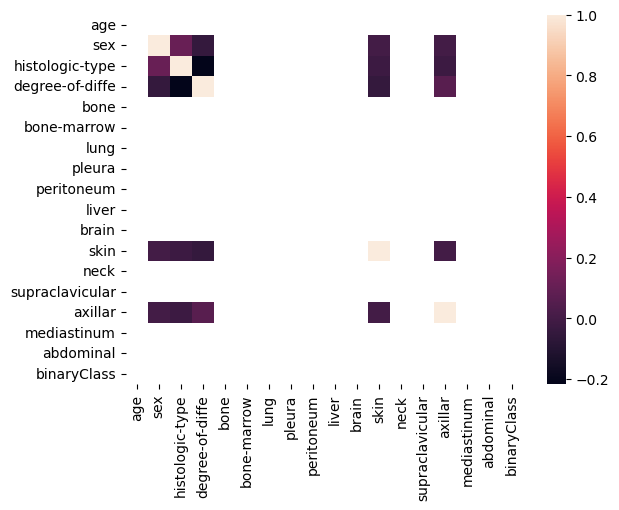

In [142]:
#b. Show the nullity correlation between columns/features
display(cancerdataraw.isna().corr(min_periods=9, numeric_only=False))

#Show a nullity correlation heatmap
sns.heatmap(cancerdataraw.isna().corr())

#Get a count and percentage of missing values according to feature types. 
{col: [cancerdataraw[col].isna().sum(), 
 f'% {np.round(np.mean(cancerdataraw[col].isnull()*100), 3)}'
 ] for col in cancerdataraw.columns if cancerdataraw[col].isnull().any()}

Note that sex, skin and axillar data appear to have an affect upon the 2 main missing data features but we cannot determine if one causes or effects the missing data yet.  

If time allows, we may take a look at using finalfit package (from here: https://finalfit.org/) in order to get a crosstable that determines whether other feature values within the dataset are explanatory variables for a specific feature.  If this is later investigated, there should be an R file or r-related jupyter notebook in the repo and you should refer to that.  


In [143]:
#Use prepackaged SciKit Learn Label Encoder that transforms string class features and labels into numeric values
#Encode target labels with value between 0 and n_classes-1.
#Reference here: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder

feature_list = list(cancerdataraw.columns) 

print(feature_list)
cancerlabels=cancerdataraw.pop('binaryClass')

le = LabelEncoder()
cancerdataraw = cancerdataraw.apply(LabelEncoder().fit_transform)
cancerlabels = cancerlabels.replace('P', 1)
cancerlabels=cancerlabels.replace('N', 0)

display(cancerdataraw)
display(cancerlabels)


['age', 'sex', 'histologic-type', 'degree-of-diffe', 'bone', 'bone-marrow', 'lung', 'pleura', 'peritoneum', 'liver', 'brain', 'skin', 'neck', 'supraclavicular', 'axillar', 'mediastinum', 'abdominal', 'binaryClass']


age  sex  histologic-type  degree-of-diffe  bone  bone-marrow  lung  \
0      2    0                3                3     0            0     0   
1      2    1                3                1     0            0     0   
2      0    0                0                3     0            0     0   
3      0    0                0                3     0            0     0   
4      0    0                0                3     0            0     0   
..   ...  ...              ...              ...   ...          ...   ...   
334    0    0                0                2     0            0     0   
335    0    1                2                1     1            0     0   
336    0    0                0                2     0            0     0   
337    0    0                0                3     1            0     1   
338    0    0                0                2     0            0     0   

     pleura  peritoneum  liver  brain  skin  neck  supraclavicular  axillar  \
0         0           0      1      0     0     0                0        0   
1         0           0      1      0     0     0                1        0   
2         1           0      0      0     1     0                0        1   
3         0           1      0      0     0     0                0        0   
4         1           1      0      0     0     0                0        0   
..      ...         ...    ...    ...   ...   ...              ...      ...   
334       0           1      0      0     0     0                0        0   
335       0           0      0      0     1     0                0        1   
336       1           1      0      0     0     0                0        0   
337       1           1      1      1     0     0                0        0   
338       1           1      0      0     0     0                0        0   

     mediastinum  abdominal  
0              0          0  
1              1          0  
2              0          0  
3              0          0  
4              0          0  
..           ...        ...  
334            0          0  
335            0          0  
336            0          0  
337            0          1  
338            0          0  

[339 rows x 17 columns]

0      1
1      1
2      0
3      0
4      0
      ..
334    0
335    1
336    0
337    0
338    0
Name: binaryClass, Length: 339, dtype: int64

66     0
114    0
7      1
137    0
328    0
      ..
188    0
71     0
106    0
270    1
102    0
Name: binaryClass, Length: 271, dtype: int64
Accuracy of Decision Tree training with standard label encoder is:  0.992619926199262
Accuracy of Decision Tree with standard label encoder is:  0.8088235294117647


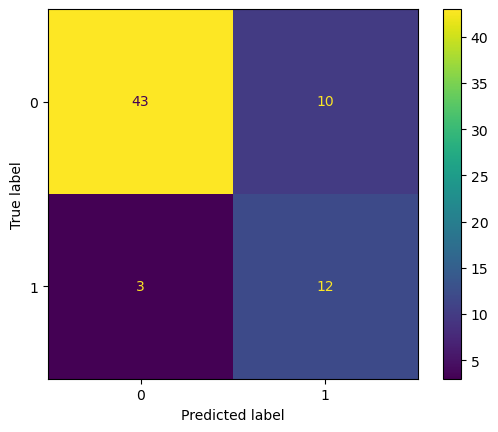

In [144]:
X_train, X_test, y_train, y_test = train_test_split(cancerdataraw, cancerlabels, test_size=0.2, random_state=42)
print(y_train)

#Create decision tree model
dtclassify = tree.DecisionTreeClassifier()
dtclassify = dtclassify.fit(X_train, y_train)

train_predictions = dtclassify.predict(X_train)

test_predictions = dtclassify.predict(X_test)
train_dt_accuracy = accuracy_score(train_predictions, y_train)
dt_accuracy = accuracy_score(test_predictions, y_test)
print("Accuracy of Decision Tree training with standard label encoder is: ", train_dt_accuracy)
print("Accuracy of Decision Tree with standard label encoder is: ", dt_accuracy)

cancerMatrix1 = cm(y_test, test_predictions, labels=[0,1])
disp=showMatrix(cancerMatrix1)
disp.plot()
plt.show()

#Note in most runs, Trainin Accuracy around 99%, Test Accuracy between .80 and .825

In [145]:
#Try again with different types of encoders based on types of data.  
#Target Encoder Reference here: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html#sklearn.preprocessing.TargetEncoder

#Did not use Ordinal encoder as that is apparently just the label encoder run on a XD number of features in the dataset instead of simply on a 1D set of labels.  

#Re-Acquire dataset from scratch
cancerdataraw = arff.loadarff('primary-tumor.arff')

#Import dataset into a panda dataframe
cancerdataraw = pd.DataFrame(cancerdataraw[0])

#View data values and information
cancerdataraw.info()
cancerdataraw.describe()
cancerdataraw.head(25)

#Layered data preprocessing to get rid of 'b' characters removing encoding
d2l1 = cancerdataraw.select_dtypes([object])
d2l2 = d2l1.stack().str.decode('utf-8').unstack()

cancerdataraw=d2l2

cancerlabels = cancerdataraw.pop('binaryClass')
cancerlabels = cancerlabels.replace('P', 1)
cancerlabels=cancerlabels.replace('N', 0)
display(cancerlabels)

#Use Ordinal Encoder on dataset:  
targ_enc = TargetEncoder()
display(cancerdataraw)
cancerdata = TargetEncoder().fit_transform(cancerdataraw, cancerlabels)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              339 non-null    object
 1   sex              339 non-null    object
 2   histologic-type  339 non-null    object
 3   degree-of-diffe  339 non-null    object
 4   bone             339 non-null    object
 5   bone-marrow      339 non-null    object
 6   lung             339 non-null    object
 7   pleura           339 non-null    object
 8   peritoneum       339 non-null    object
 9   liver            339 non-null    object
 10  brain            339 non-null    object
 11  skin             339 non-null    object
 12  neck             339 non-null    object
 13  supraclavicular  339 non-null    object
 14  axillar          339 non-null    object
 15  mediastinum      339 non-null    object
 16  abdominal        339 non-null    object
 17  binaryClass      339 non-null    ob

0      1
1      1
2      0
3      0
4      0
      ..
334    0
335    1
336    0
337    0
338    0
Name: binaryClass, Length: 339, dtype: int64

age     sex histologic-type degree-of-diffe bone bone-marrow lung  \
0     >=60  female               ?               ?   no          no   no   
1     >=60    male               ?          poorly   no          no   no   
2    30-59  female           adeno               ?   no          no   no   
3    30-59  female           adeno               ?   no          no   no   
4    30-59  female           adeno               ?   no          no   no   
..     ...     ...             ...             ...  ...         ...  ...   
334  30-59  female           adeno            well   no          no   no   
335  30-59    male      epidermoid          poorly  yes          no   no   
336  30-59  female           adeno            well   no          no   no   
337  30-59  female           adeno               ?  yes          no  yes   
338  30-59  female           adeno            well   no          no   no   

    pleura peritoneum liver brain skin neck supraclavicular axillar  \
0       no         no   yes    no   no   no              no      no   
1       no         no   yes    no   no   no             yes      no   
2      yes         no    no    no  yes   no              no     yes   
3       no        yes    no    no   no   no              no      no   
4      yes        yes    no    no   no   no              no      no   
..     ...        ...   ...   ...  ...  ...             ...     ...   
334     no        yes    no    no   no   no              no      no   
335     no         no    no    no  yes   no              no     yes   
336    yes        yes    no    no   no   no              no      no   
337    yes        yes   yes   yes   no   no              no      no   
338    yes        yes    no    no   no   no              no      no   

    mediastinum abdominal  
0            no        no  
1           yes        no  
2            no        no  
3            no        no  
4            no        no  
..          ...       ...  
334          no        no  
335          no        no  
336          no        no  
337          no       yes  
338          no        no  

[339 rows x 17 columns]

[[0.17143492 0.1647205  0.59533096 ... 0.25815067 0.12219228 0.29023673]
 [0.17143492 0.33507417 0.59533096 ... 0.25815067 0.57528267 0.29023673]
 [0.26459904 0.17400314 0.10267792 ... 0.18045123 0.11831828 0.26509007]
 ...
 [0.27470026 0.15873987 0.09925354 ... 0.25711328 0.14111768 0.26621253]
 [0.26772859 0.15323178 0.08780518 ... 0.26223117 0.14393975 0.14807313]
 [0.26772859 0.15323178 0.08780518 ... 0.26223117 0.14393975 0.30079224]]
Accuracy of Decision Tree with Target Encoding data then training is:  1.0
Accuracy of Decision Tree with Target Encoding data then training is:  0.7647058823529411


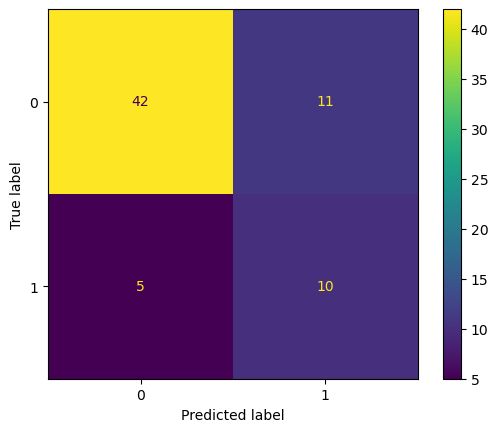

In [146]:
print(cancerdata)

X_train2, X_test2, y_train2, y_test2 = train_test_split(cancerdata, cancerlabels, test_size=0.2, random_state=42)


dtclassify2 = tree.DecisionTreeClassifier()
dtclassify2 = dtclassify2.fit(X_train2, y_train2)
train_predictions2 = dtclassify2.predict(X_train2)

test_predictions2 = dtclassify2.predict(X_test2)

train_dt_accuracy2 = accuracy_score(train_predictions2, y_train2)
dt_accuracy2 = accuracy_score(test_predictions2, y_test2)
print("Accuracy of Decision Tree with Target Encoding data then training is: ", train_dt_accuracy2)
print("Accuracy of Decision Tree with Target Encoding data then training is: ", dt_accuracy2)

cancerMatrix2 = cm(y_test2, test_predictions2, labels=[0,1])
disp=showMatrix(cancerMatrix2)
disp.plot()
plt.show()


#Note that in the initial run of this,  target encoding results in perfect train fit (1.0), but reduced test fit (.75). 
#In the next run, target encoding resulted in .9926 train, .89 test
#Target Encoding is known to be subject to overfitting, and generally, the target encoding should be performed on an independent dataset that is NOT the train or test set.  

In [147]:
#Final version uses one-hot encoding for categorical data:  
#Acquire dataset
cancerdataraw = arff.loadarff('primary-tumor.arff')

#Import dataset into a panda dataframe
cancerdataraw = pd.DataFrame(cancerdataraw[0])

#View data values and information
cancerdataraw.info()
cancerdataraw.describe()
cancerdataraw.head(25)

#Layered data preprocessing to get rid of 'b' characters removing encoding
d2l1 = cancerdataraw.select_dtypes([object])
d2l2 = d2l1.stack().str.decode('utf-8').unstack()

cancerdataraw=d2l2

cancerlabels = cancerdataraw.pop('binaryClass')
cancerlabels = cancerlabels.replace('P', 1)
cancerlabels=cancerlabels.replace('N', 0)
display(cancerlabels)

#Use OnehotEncoder on dataset:  
onehot = OneHotEncoder()
cancerdata = OneHotEncoder().fit_transform(cancerdataraw)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              339 non-null    object
 1   sex              339 non-null    object
 2   histologic-type  339 non-null    object
 3   degree-of-diffe  339 non-null    object
 4   bone             339 non-null    object
 5   bone-marrow      339 non-null    object
 6   lung             339 non-null    object
 7   pleura           339 non-null    object
 8   peritoneum       339 non-null    object
 9   liver            339 non-null    object
 10  brain            339 non-null    object
 11  skin             339 non-null    object
 12  neck             339 non-null    object
 13  supraclavicular  339 non-null    object
 14  axillar          339 non-null    object
 15  mediastinum      339 non-null    object
 16  abdominal        339 non-null    object
 17  binaryClass      339 non-null    ob

0      1
1      1
2      0
3      0
4      0
      ..
334    0
335    1
336    0
337    0
338    0
Name: binaryClass, Length: 339, dtype: int64

In [148]:
print(cancerdata)

X_train3, X_test3, y_train3, y_test3 = train_test_split(cancerdata, cancerlabels, test_size=0.2, random_state=42)


dtclassify3 = tree.DecisionTreeClassifier()
dtclassify3 = dtclassify3.fit(X_train3, y_train3)
train_predictions3 = dtclassify3.predict(X_train3)

test_predictions3 = dtclassify3.predict(X_test3)

train_dt_accuracy3 = accuracy_score(train_predictions3, y_train3)
dt_accuracy3 = accuracy_score(test_predictions3, y_test3)
print("Accuracy of Decision Tree with One Hot Encoding data then training is: ", train_dt_accuracy3)
print("Accuracy of Decision Tree with One Hot Encoding data then training is: ", dt_accuracy3)


#OneHot encoding usually results in training accuracy around 99% and test accuracy around .79-.85.  Similar run end accuracy compared to labelencoding.   

#Note in most runs, Training Accuracy around 99%, Test Accuracy between .80 and .85

  (0, 2)	1.0
  (0, 4)	1.0
  (0, 6)	1.0
  (0, 10)	1.0
  (0, 14)	1.0
  (0, 16)	1.0
  (0, 18)	1.0
  (0, 20)	1.0
  (0, 22)	1.0
  (0, 25)	1.0
  (0, 26)	1.0
  (0, 29)	1.0
  (0, 31)	1.0
  (0, 33)	1.0
  (0, 36)	1.0
  (0, 38)	1.0
  (0, 40)	1.0
  (1, 2)	1.0
  (1, 5)	1.0
  (1, 6)	1.0
  (1, 12)	1.0
  (1, 14)	1.0
  (1, 16)	1.0
  (1, 18)	1.0
  (1, 20)	1.0
  :	:
  (337, 25)	1.0
  (337, 27)	1.0
  (337, 29)	1.0
  (337, 31)	1.0
  (337, 33)	1.0
  (337, 36)	1.0
  (337, 38)	1.0
  (337, 41)	1.0
  (338, 0)	1.0
  (338, 4)	1.0
  (338, 7)	1.0
  (338, 13)	1.0
  (338, 14)	1.0
  (338, 16)	1.0
  (338, 18)	1.0
  (338, 21)	1.0
  (338, 23)	1.0
  (338, 24)	1.0
  (338, 26)	1.0
  (338, 29)	1.0
  (338, 31)	1.0
  (338, 33)	1.0
  (338, 36)	1.0
  (338, 38)	1.0
  (338, 40)	1.0
Accuracy of Decision Tree with One Hot Encoding data then training is:  0.992619926199262
Accuracy of Decision Tree with One Hot Encoding data then training is:  0.8235294117647058


## Exploratory Data Analysis:  
We will attempt to analyze and summarize each dataset, identifying characteristics, patterns and relationships within the data prior to applying any sort machine learning techniques.

### MetaInformation

Prior to performing any analysis on the data we can reference the data repository metadata and data analysis. 


#### Tumor Data
Our Tumor dataset was obtained from https://www.openml.org/search?type=data&sort=runs&id=171&status=active and the data repository contains some initial analysis on the data.  Several features contain missing data and 2 features ('degree-of-diffe' and 'histologic-type' contain a large number of missing values.  155 and 67 respectively. A large number of instances also have individual instances contain some form of missing value (207 of the total 339 which is significant).  Therefore simply deleting any instances with missing values would significantly limit out dataset. Several distribution plots are readily available on the analysis page and imported below.  





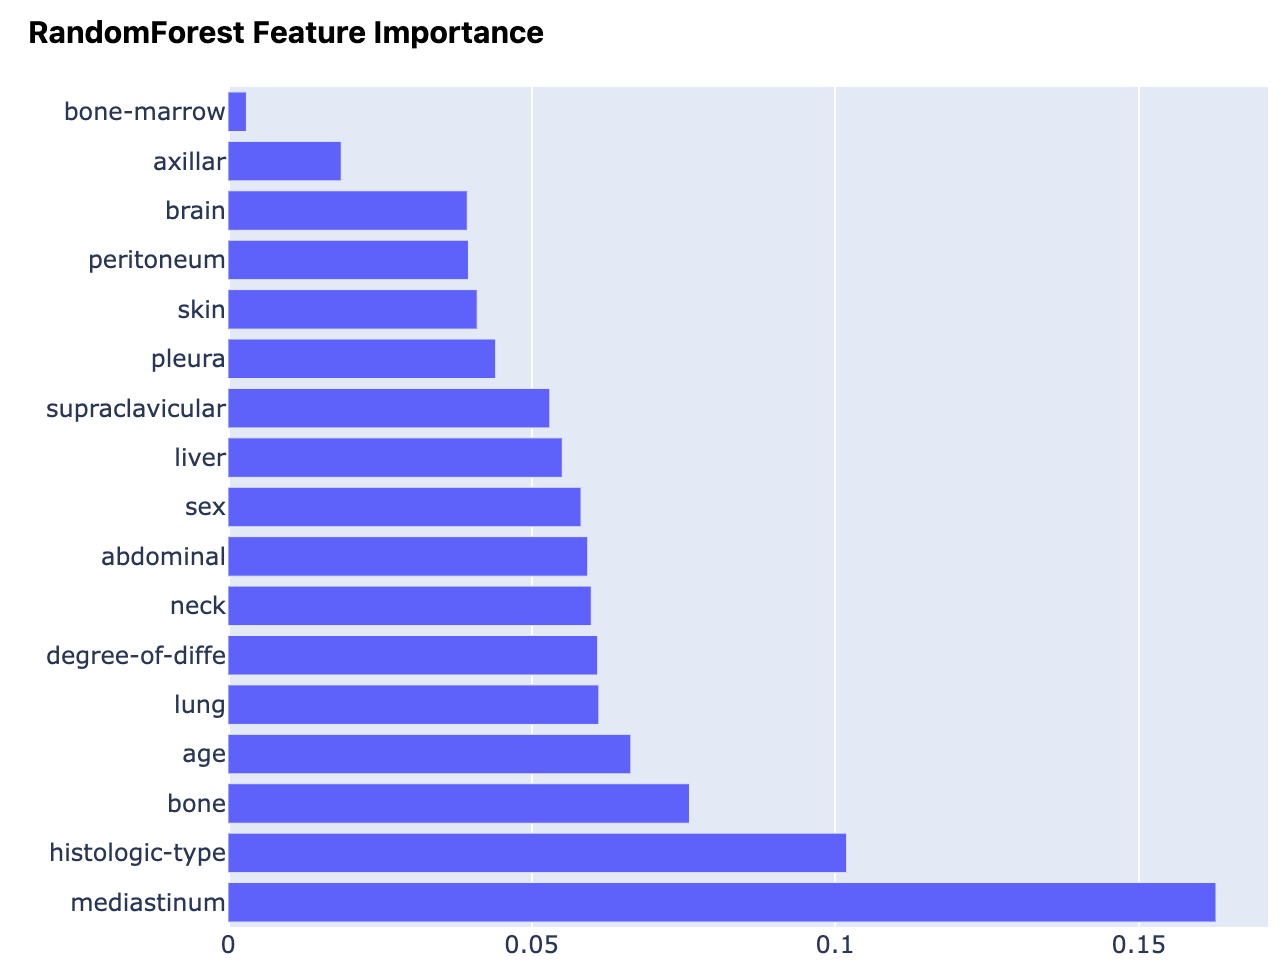

In [133]:
Image(filename='img/fig1.png', width=600) 


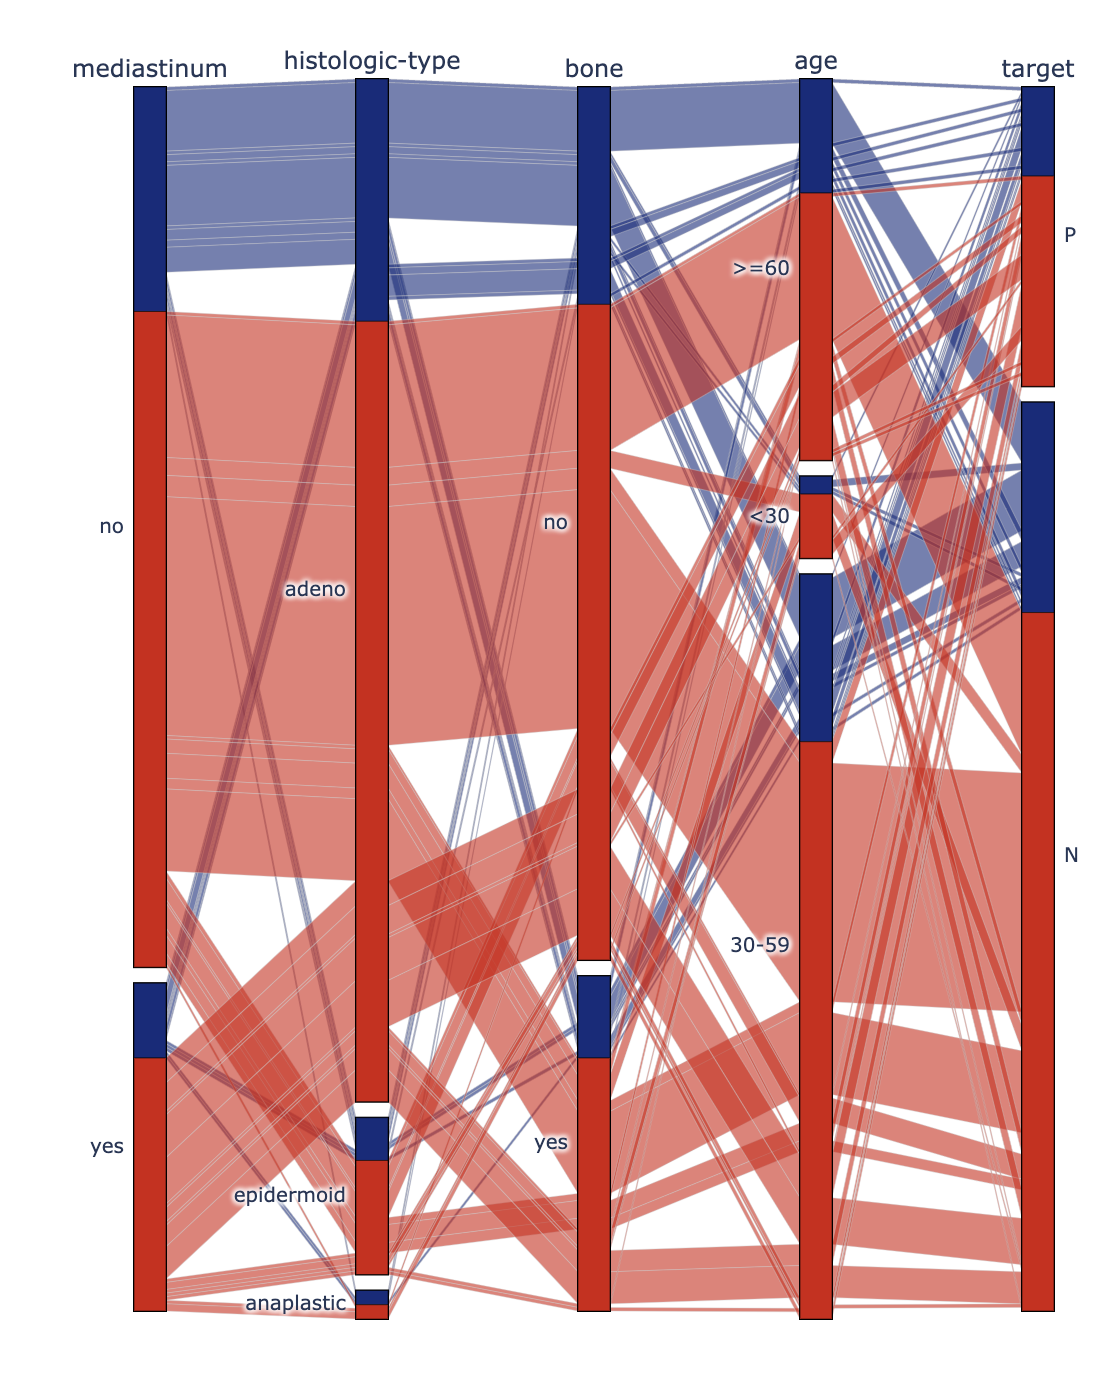

In [134]:
Image(filename='img/fig2.png', width=600)
#This particular graph shows how certainfeatures have affects upon the overal target (positive/negative).
#median to older age greatly affects overall positive/negative as does histologic-type.  For example, adeno histologic type seems to have a large effect on target positive, vs

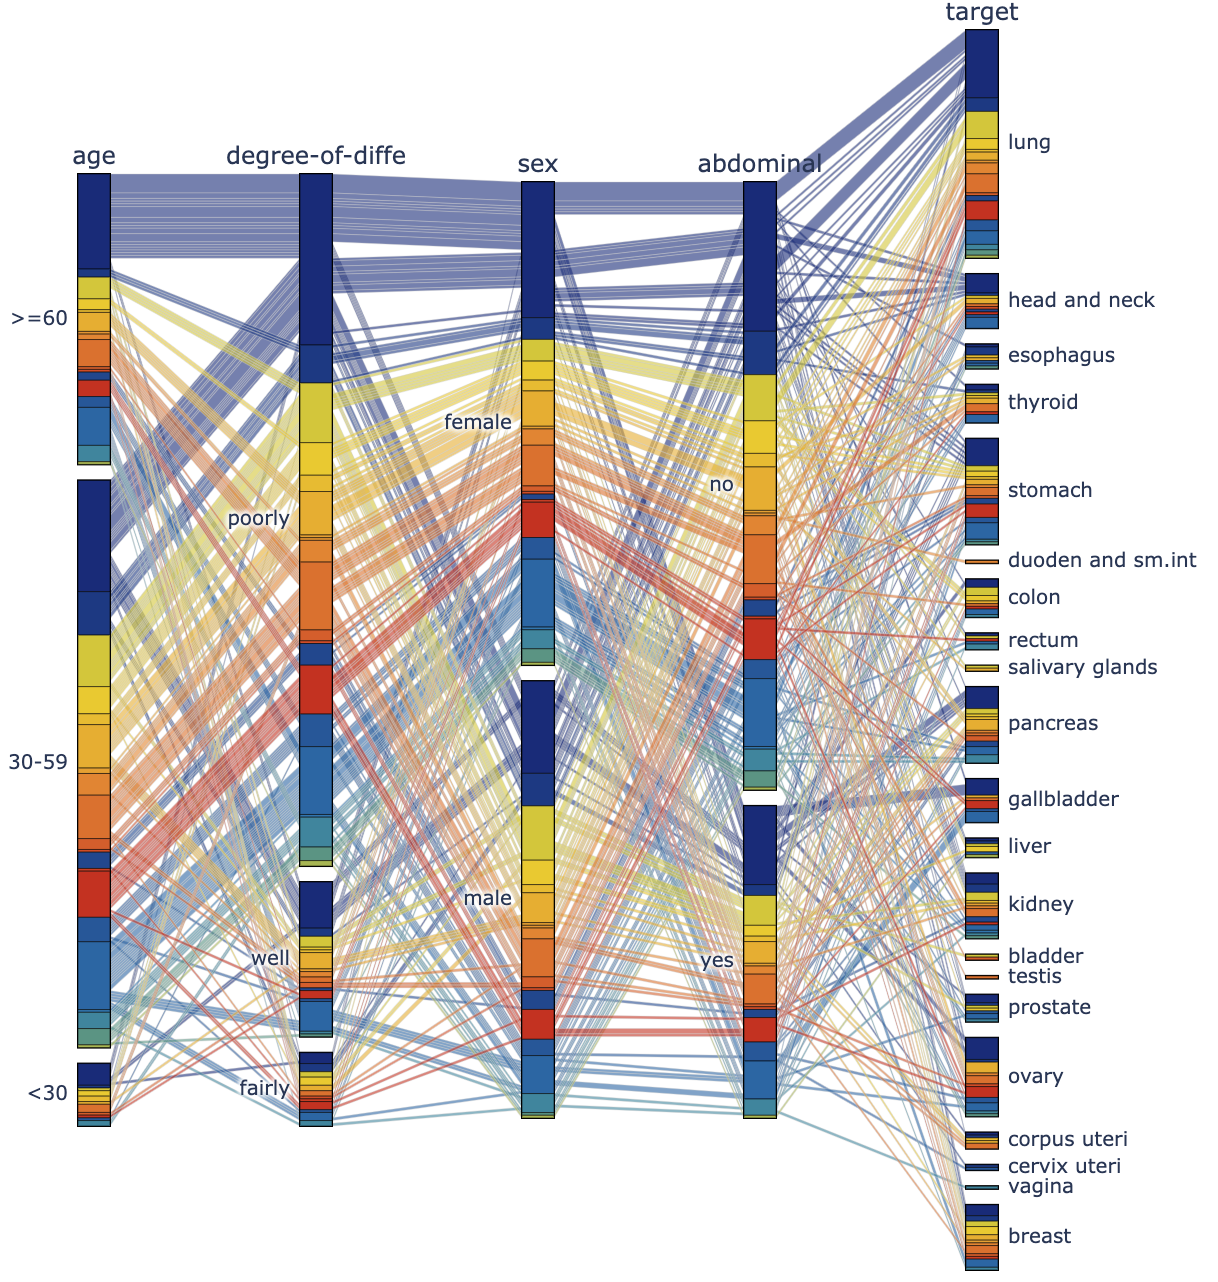

In [135]:
Image(filename='img/fig3.png', width=600)
#The following graph represents the top four features and interaction upon target classes.
#This would indicate that a decision tree should consider those data features first.  